In [38]:
import os
import math
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import squareform, cdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, mean_squared_error, r2_score, calinski_harabasz_score
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# датасеты:
# https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression/data
# https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data


In [39]:
# Метрики расстояний
def euclidean_distance(p1, p2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))
def euclidean_distance2(p1, p2):
    return sum((a - b) ** 2 for a, b in zip(p1, p2))
def manhattan_distance(p1, p2):
    return sum(abs(a - b) for a, b in zip(p1, p2))
def chebyshev_distance(p1, p2):
    return max(abs(a - b) for a, b in zip(p1, p2))
def minkowski_distance(p1, p2, p, r):
    return sum(abs(a - b) ** p for a, b in zip(p1, p2)) ** (1 / r)
def mahalanobis_distance(p1, p2, cov_inv):
    delta = np.array(p1) - np.array(p2)
    return np.sqrt(np.dot(np.dot(delta.T, cov_inv), delta))
def spearman_rank_correlation(x, y):
    n = len(x)
    rank_x = {val: rank for rank, val in enumerate(sorted(x), 1)}
    rank_y = {val: rank for rank, val in enumerate(sorted(y), 1)}
    d_squared = sum((rank_x[a] - rank_y[b]) ** 2 for a, b in zip(x, y))
    return 1 - (6 * d_squared) / (n * (n**2 - 1))
def kendall_tau(x, y):
    n = len(x)
    concordant = discordant = 0
    for i in range(n):
        for j in range(i + 1, n):
            a = x[i] - x[j]
            b = y[i] - y[j]
            if a * b > 0:
                concordant += 1
            elif a * b < 0:
                discordant += 1
    return (concordant - discordant) / (0.5 * n * (n - 1))
def pearson_correlation(x, y):
    n = len(x)
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    num = sum((a - mean_x) * (b - mean_y) for a, b in zip(x, y))
    den_x = sum((a - mean_x) ** 2 for a in x)
    den_y = sum((b - mean_y) ** 2 for b in y)
    return num / math.sqrt(den_x * den_y)


2. Загрузка и первичная обработка данных

In [40]:
data = pd.read_excel('dataset5.xlsx')
print("Типы данных в датасете:")
print(data.dtypes)

Типы данных в датасете:
Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object


3. Этап 1 — Преобразование категориальных данных

In [41]:
# Преобразование текстовых столбцов в числовые значения
data['Stage_fear'] = data['Stage_fear'].map({'Yes': 1, 'No': 0})  # Заменяем 'Yes' на 1, 'No' на 0
data['Drained_after_socializing'] = data['Drained_after_socializing'].map({'Yes': 1, 'No': 0})  # Аналогично

# Преобразование категории 'Personality' в числа (например, через словарь)
personality_map = {'Introvert': 0, 'Extrovert': 1}  # Можно добавить и другие типы, если будут
data['Personality'] = data['Personality'].map(personality_map)

#  код для другого датасета
# Пример для первого датасета:
# data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
print(data.head())

   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0               4.0           0                      4.0            6.0   
1               9.0           1                      0.0            0.0   
2               9.0           1                      1.0            2.0   
3               0.0           0                      6.0            7.0   
4               3.0           0                      9.0            4.0   

   Drained_after_socializing  Friends_circle_size  Post_frequency  Personality  
0                          0                 13.0             5.0            1  
1                          1                  0.0             3.0            0  
2                          1                  5.0             2.0            0  
3                          0                 14.0             8.0            1  
4                          0                  8.0             5.0            1  


Проверка и обработка пропусков

In [42]:
print("\n=== 2 ЭТАП: Проверка и обработка пропусков ===")

# Проверка пропусков
missing = data.isnull().sum()
print("Пропуски по столбцам (до обработки):")
print(missing[missing > 0])

# Обработка пропусков
for col in data.columns:
    if data[col].isnull().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            median_value = data[col].median()
            data[col] = data[col].fillna(median_value)
            print(f" → {col}: заполнено медианой ({median_value})")
        else:
            mode_value = data[col].mode()[0]
            data[col] = data[col].fillna(mode_value)
            print(f" → {col}: заполнено модой ({mode_value})")

# Повторная проверка
print("\nПропуски после заполнения:")
print(data.isnull().sum().sum(), "всего пропусков")



=== 2 ЭТАП: Проверка и обработка пропусков ===
Пропуски по столбцам (до обработки):
Series([], dtype: int64)

Пропуски после заполнения:
0 всего пропусков


5. Этап 3 — Удаление выбросов по z-оценке

![Дендрит](3sigm.png)

In [43]:
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
data = data[(z_scores < 3).all(axis=1)]
print(f"Размер данных после удаления выбросов: {data.shape}")

Размер данных после удаления выбросов: (2900, 8)


6. Этап 4 — Нормализация MinMaxScaler

In [44]:
num_cols = data.select_dtypes(include=['float64', 'int64']).columns.difference(['Extracurricular Activities'])
scaler = MinMaxScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])
print(data.head())

   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0          0.363636         0.0                      0.4       0.857143   
1          0.818182         1.0                      0.0       0.000000   
2          0.818182         1.0                      0.1       0.285714   
3          0.000000         0.0                      0.6       1.000000   
4          0.272727         0.0                      0.9       0.571429   

   Drained_after_socializing  Friends_circle_size  Post_frequency  Personality  
0                        0.0             0.866667             0.5          1.0  
1                        1.0             0.000000             0.3          0.0  
2                        1.0             0.333333             0.2          0.0  
3                        0.0             0.933333             0.8          1.0  
4                        0.0             0.533333             0.5          1.0  


Вычисляем и визуализируем матрицу корреляции

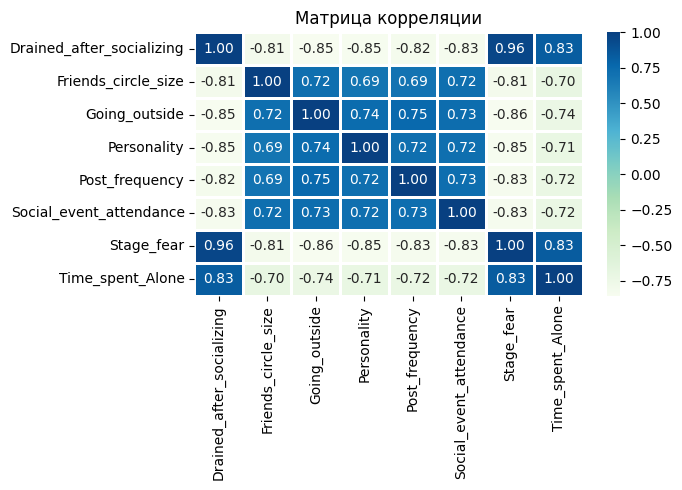

In [45]:
correlation_matrix = data[num_cols].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=1, cmap='GnBu')
plt.title('Матрица корреляции')
plt.tight_layout()
plt.show()

# **Матрица «объект-признак»**
Каждая строка представляет объект (Человек), а столбцы — признаки (Время в одиночестве, Страх сцены, Посещение мероприятий, Выходы на улицу, Усталость после общения, Размер круга друзей, Частота публикаций, Тип личности)

In [46]:
display(data.head())
display(data.tail())

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0.363636,0.0,0.4,0.857143,0.0,0.866667,0.5,1.0
1,0.818182,1.0,0.0,0.000000,1.0,0.000000,0.3,0.0
2,0.818182,1.0,0.1,0.285714,1.0,0.333333,0.2,0.0
3,0.000000,0.0,0.6,1.000000,0.0,0.933333,0.8,1.0
4,0.272727,0.0,0.9,0.571429,0.0,0.533333,0.5,1.0


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
2895,0.272727,0.0,0.7,0.857143,0.0,0.400000,0.6,1.0
2896,0.272727,0.0,0.8,0.428571,0.0,0.933333,0.9,1.0
2897,0.363636,1.0,0.1,0.142857,1.0,0.266667,0.0,0.0
2898,1.000000,1.0,0.1,0.428571,1.0,0.133333,0.0,0.0
2899,0.272727,0.0,0.6,0.857143,0.0,0.400000,0.9,1.0


# **Матрица «объект-объект»**

Представляет собой матрицу попарных расстояний между всеми объектами (людьми). Для её формирования используется евклидово расстояние на основе нормализованных данных.

In [63]:
from scipy.spatial import distance
import gower
from sklearn.metrics import pairwise_distances
# Вычисляем матрицу расстояний (объект-объект)
# distance_matrix = cdist(data, data, metric='euclidean')
# D = distance.cdist(data, data, metric='cityblock')

distance_matrix = gower.gower_matrix(data)
D = gower.gower_matrix(data)
# Выводим размер матрицы
print(f"Форма матрицы расстояний: {distance_matrix.shape}")
pd.DataFrame(distance_matrix)

Форма матрицы расстояний: (2900, 2900)


,0,1,2,3,4,5,6,7,8,9,...,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899
0,0.000000,0.722294,0.644913,0.134145,0.151245,0.160281,0.191071,0.195942,0.667587,0.132955,...,0.690097,0.616180,0.701461,0.551461,0.187800,0.119697,0.173268,0.639286,0.699784,0.144697
1,0.722294,0.000000,0.102381,0.856439,0.718777,0.730195,0.706223,0.746807,0.077435,0.855249,...,0.057197,0.156115,0.045833,0.195833,0.750403,0.725325,0.788420,0.158009,0.142965,0.750325
2,0.644913,0.102381,0.000000,0.779058,0.641396,0.652814,0.628842,0.669426,0.083387,0.777868,...,0.092911,0.089448,0.081548,0.181548,0.673022,0.647944,0.711039,0.108009,0.090584,0.672944
3,0.134145,0.856439,0.779058,0.000000,0.212662,0.151245,0.225216,0.159632,0.801732,0.051190,...,0.824242,0.750325,0.835606,0.685606,0.181036,0.156115,0.143019,0.773431,0.833929,0.131115
4,0.151245,0.718777,0.641396,0.212662,0.000000,0.094751,0.062554,0.069697,0.664069,0.161472,...,0.686580,0.612662,0.697944,0.547944,0.103222,0.089881,0.130357,0.635768,0.696266,0.139881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0.119697,0.725325,0.647944,0.156115,0.089881,0.040584,0.110768,0.092911,0.670617,0.129924,...,0.693128,0.619210,0.704491,0.554491,0.193103,0.000000,0.170238,0.642316,0.702814,0.050000
2896,0.173268,0.788420,0.711039,0.143019,0.130357,0.175108,0.107197,0.100054,0.733712,0.108496,...,0.756223,0.682305,0.767587,0.617587,0.131198,0.170238,0.000000,0.705411,0.765909,0.145238
2897,0.639286,0.158009,0.108009,0.773431,0.635768,0.647186,0.623214,0.663799,0.174729,0.772240,...,0.125812,0.068561,0.137175,0.237175,0.667395,0.642316,0.705411,0.000000,0.131926,0.667316
2898,0.699784,0.142965,0.090584,0.833929,0.696266,0.707684,0.683712,0.724297,0.065530,0.832738,...,0.133496,0.155032,0.122132,0.255465,0.727892,0.702814,0.765909,0.131926,0.000000,0.727814


7. Этап 5 — Подвыборка и матрица расстояний

In [85]:
import gower
import numpy as np

def compute_distance_matrix(data, metric):
    n = len(data)
    matrix = [[0.0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                if metric == 'euclidean':
                    dist = euclidean_distance2(data[i], data[j])
                elif metric == 'manhattan':
                    dist = manhattan_distance(data[i], data[j])
                elif metric == 'chebyshev':
                    dist = chebyshev_distance(data[i], data[j])
                elif metric == 'minkowski':
                    dist = minkowski_distance(data[i], data[j], 2, 3)
                elif metric == 'mahalanobis':
                    dist = mahalanobis_distance(data[i], data[j], np.linalg.inv(np.cov(np.array(data).T)))
                elif metric == 'spearman':
                    dist = spearman_rank_correlation(data[i], data[j])
                elif metric == 'kendall':
                    dist = kendall_tau(data[i], data[j])
                elif metric == 'pearson':
                    dist = pearson_correlation(data[i], data[j])
                elif metric == 'gower':
                    # Вычисляем расстояние Говера между двумя объектами
                    dist = gower.gower_matrix(np.array([data[i], data[j]]))[0, 1]
                else:
                    raise ValueError(f"Неизвестная метрика: {metric}")
                matrix[i][j] = dist
    return matrix

# Пример использования:
X = data.sample(frac=0.4, random_state=42).reset_index(drop=True)
X_t = compute_distance_matrix(X.values, 'gower')
pd.DataFrame(X_t).head()


,0,1,2,3,4,5,6,7,8,9,...,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159
0,0.000,1.0,0.625,0.500,0.625,0.625,0.625,0.875,0.625,0.500,...,0.500,1.000,0.625,0.500,0.875,1.000,1.000,0.875,0.500,0.500
1,1.000,0.0,1.000,1.000,1.000,1.000,1.000,0.500,1.000,1.000,...,1.000,0.375,0.875,1.000,0.625,0.625,0.625,0.500,1.000,1.000
2,0.625,1.0,0.000,0.625,0.375,0.500,0.250,1.000,0.375,0.375,...,0.500,1.000,0.625,0.375,1.000,1.000,1.000,1.000,0.375,0.625
3,0.500,1.0,0.625,0.000,0.375,0.625,0.625,1.000,0.625,0.500,...,0.500,1.000,0.375,0.500,1.000,1.000,1.000,1.000,0.500,0.500
4,0.625,1.0,0.375,0.375,0.000,0.625,0.375,1.000,0.500,0.500,...,0.375,1.000,0.500,0.500,1.000,1.000,1.000,1.000,0.375,0.500


8. Этап 6 — Гистограмма расстояний

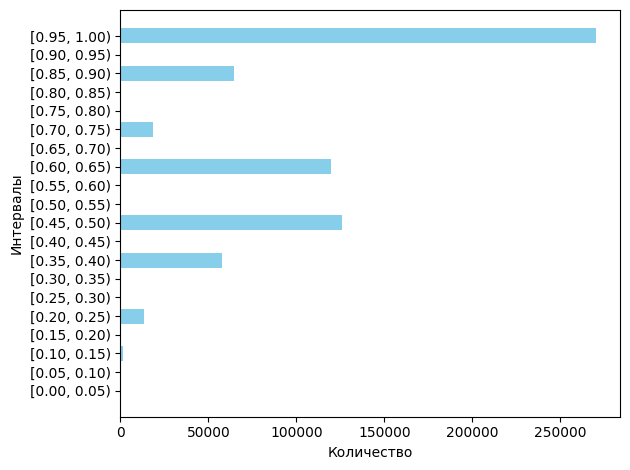

In [86]:
def build_distance_histogram(distance_matrix, bins=20):
    n = len(distance_matrix)
    distances = []
    for i in range(n):
        for j in range(i + 1, n):
            distances.append(distance_matrix[i][j])
    
    min_d, max_d = min(distances), max(distances)
    step = (max_d - min_d) / bins
    histogram = [0] * bins
    for d in distances:
        index = int((d - min_d) / step)
        if index == bins:
            index -= 1
        histogram[index] += 1
    
    binss = [f"[{min_d + i * step:.2f}, {min_d + (i + 1) * step:.2f})" for i in range(bins)]
    plt.barh(binss, histogram, color='skyblue')
    plt.xlabel('Количество')
    plt.ylabel('Интервалы')
    plt.tight_layout()
    plt.show()

build_distance_histogram(X_t)


9. Этап 7 — Кластеризация по Вроцлавской таксономии

In [87]:
distance_matrix = np.array(X_t)

print("Этап 1: Матрица расстояний (первые 5 строк):")
display(pd.DataFrame(distance_matrix).round(2).head())

# Этап 2: Найти ближайший объект для каждой точки (кроме самой себя)
nearest_neighbors = np.argmin(np.where(distance_matrix == 0, np.inf, distance_matrix), axis=1)
print("Этап 2: Ближайшие объекты для каждой точки:")
print(nearest_neighbors)



Этап 1: Матрица расстояний (первые 5 строк):


,0,1,2,3,4,5,6,7,8,9,...,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159
0,0.00,1.0,0.62,0.50,0.62,0.62,0.62,0.88,0.62,0.50,...,0.50,1.00,0.62,0.50,0.88,1.00,1.00,0.88,0.50,0.50
1,1.00,0.0,1.00,1.00,1.00,1.00,1.00,0.50,1.00,1.00,...,1.00,0.38,0.88,1.00,0.62,0.62,0.62,0.50,1.00,1.00
2,0.62,1.0,0.00,0.62,0.38,0.50,0.25,1.00,0.38,0.38,...,0.50,1.00,0.62,0.38,1.00,1.00,1.00,1.00,0.38,0.62
3,0.50,1.0,0.62,0.00,0.37,0.63,0.62,1.00,0.62,0.50,...,0.50,1.00,0.38,0.50,1.00,1.00,1.00,1.00,0.50,0.50
4,0.62,1.0,0.38,0.37,0.00,0.62,0.38,1.00,0.50,0.50,...,0.38,1.00,0.50,0.50,1.00,1.00,1.00,1.00,0.38,0.50


Этап 2: Ближайшие объекты для каждой точки:
[ 864  280 1077 ...  301   34   27]


Этапа 3 — построение связей (рёбер) между ближайшими объектами:

In [88]:
# Этап 3: Построить связи (рёбра) между ближайшими объектами
edges = [(i, nearest_neighbors[i]) for i in range(len(nearest_neighbors))]

print("Этап 3: Связи между ближайшими объектами (пары индексов):")
print(edges[:20])  # Покажем первые 20 связей, чтобы не засорять вывод


Этап 3: Связи между ближайшими объектами (пары индексов):
[(0, np.int64(864)), (1, np.int64(280)), (2, np.int64(1077)), (3, np.int64(46)), (4, np.int64(175)), (5, np.int64(435)), (6, np.int64(85)), (7, np.int64(290)), (8, np.int64(136)), (9, np.int64(911)), (10, np.int64(125)), (11, np.int64(14)), (12, np.int64(621)), (13, np.int64(358)), (14, np.int64(20)), (15, np.int64(113)), (16, np.int64(465)), (17, np.int64(1020)), (18, np.int64(1021)), (19, np.int64(177))]


In [89]:
# Этап 4: Объединить пары в кластеры 1-го порядка (без пересечений)
clusters = []
visited = set()

for i, j in edges:
    if i not in visited and j not in visited:
        clusters.append(set([i, j]))
        visited.update([i, j])

# Добавляем одиночные кластеры для точек, не вошедших в пары
for i in range(len(distance_matrix)):
    if i not in visited:
        clusters.append(set([i]))

print("Этап 4: Кластеры 1-го порядка:")
for idx, cluster in enumerate(clusters):
    print(f"Кластер {idx}: {sorted(cluster)}")


Этап 4: Кластеры 1-го порядка:
Кластер 0: [0, np.int64(864)]
Кластер 1: [1, np.int64(280)]
Кластер 2: [2, np.int64(1077)]
Кластер 3: [3, np.int64(46)]
Кластер 4: [4, np.int64(175)]
Кластер 5: [5, np.int64(435)]
Кластер 6: [6, np.int64(85)]
Кластер 7: [7, np.int64(290)]
Кластер 8: [8, np.int64(136)]
Кластер 9: [9, np.int64(911)]
Кластер 10: [10, np.int64(125)]
Кластер 11: [11, np.int64(14)]
Кластер 12: [12, np.int64(621)]
Кластер 13: [13, np.int64(358)]
Кластер 14: [15, np.int64(113)]
Кластер 15: [16, np.int64(465)]
Кластер 16: [17, np.int64(1020)]
Кластер 17: [18, np.int64(1021)]
Кластер 18: [19, np.int64(177)]
Кластер 19: [20, np.int64(492)]
Кластер 20: [21, np.int64(766)]
Кластер 21: [22, np.int64(77)]
Кластер 22: [23, np.int64(296)]
Кластер 23: [24, np.int64(975)]
Кластер 24: [25, np.int64(794)]
Кластер 25: [26, np.int64(1142)]
Кластер 26: [27, np.int64(993)]
Кластер 27: [28, np.int64(1096)]
Кластер 28: [29, np.int64(1131)]
Кластер 29: [30, np.int64(126)]
Кластер 30: [31, np.int64(5

In [90]:
import numpy as np

# Функция для вычисления минимального расстояния между двумя кластерами
def cluster_distance(c1, c2, distance_matrix):
    min_dist = np.inf
    for i in c1:
        for j in c2:
            if distance_matrix[i][j] < min_dist:
                min_dist = distance_matrix[i][j]
    return min_dist

# Этап 5: Иерархическое объединение кластеров
clusters_current = clusters.copy()

iteration = 0
while len(clusters_current) > 1:
    iteration += 1
    # Найти пару кластеров с минимальным расстоянием
    min_dist = np.inf
    pair_to_merge = (None, None)
    for i in range(len(clusters_current)):
        for j in range(i + 1, len(clusters_current)):
            dist = cluster_distance(clusters_current[i], clusters_current[j], distance_matrix)
            if dist < min_dist:
                min_dist = dist
                pair_to_merge = (i, j)
    
    # Объединить два кластера
    i, j = pair_to_merge
    new_cluster = clusters_current[i].union(clusters_current[j])
    
    # Удалить старые и добавить новый кластер
    clusters_current = [clusters_current[k] for k in range(len(clusters_current)) if k != i and k != j]
    clusters_current.append(new_cluster)
    
    print(f"Итерация {iteration}: Объединены кластеры {i} и {j} с расстоянием {min_dist:.4f}. Осталось кластеров: {len(clusters_current)}")

print("\nИтоговый кластер содержит все объекты:")
print(sorted(clusters_current[0]))


Итерация 1: Объединены кластеры 6 и 624 с расстоянием 0.0000. Осталось кластеров: 757
Итерация 2: Объединены кластеры 6 и 239 с расстоянием 0.0000. Осталось кластеров: 756
Итерация 3: Объединены кластеры 6 и 451 с расстоянием 0.0000. Осталось кластеров: 755
Итерация 4: Объединены кластеры 28 и 487 с расстоянием 0.0000. Осталось кластеров: 754
Итерация 5: Объединены кластеры 28 и 558 с расстоянием 0.0000. Осталось кластеров: 753
Итерация 6: Объединены кластеры 37 и 530 с расстоянием 0.0000. Осталось кластеров: 752
Итерация 7: Объединены кластеры 43 и 623 с расстоянием 0.0000. Осталось кластеров: 751
Итерация 8: Объединены кластеры 46 и 552 с расстоянием 0.0000. Осталось кластеров: 750
Итерация 9: Объединены кластеры 47 и 584 с расстоянием 0.0000. Осталось кластеров: 749
Итерация 10: Объединены кластеры 51 и 514 с расстоянием 0.0000. Осталось кластеров: 748
Итерация 11: Объединены кластеры 72 и 426 с расстоянием 0.0000. Осталось кластеров: 747
Итерация 12: Объединены кластеры 75 и 423 с 

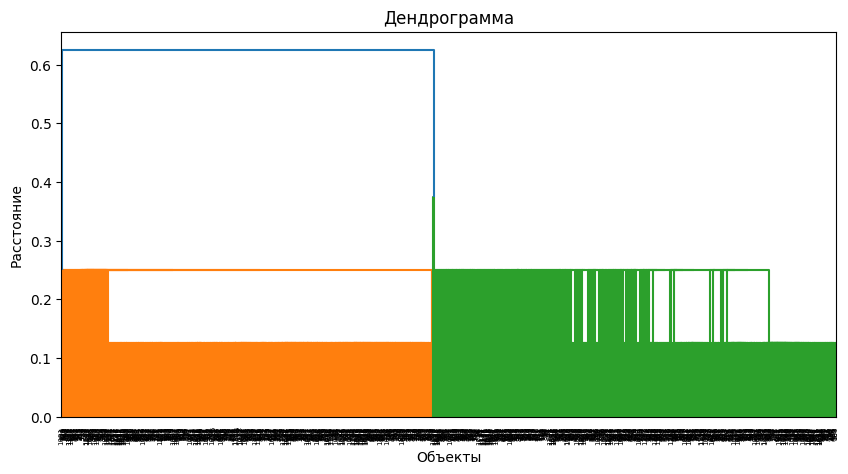

In [91]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# Преобразуем матрицу расстояний к condensed form
condensed_dist = squareform(distance_matrix)

# Иерархическая кластеризация
Z = linkage(condensed_dist, method='single')

# Визуализация дендрограммы
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Дендрограмма")
plt.xlabel("Объекты")
plt.ylabel("Расстояние")
plt.show()


## Удалить кол-вокластеров-1 самых длинных ребер

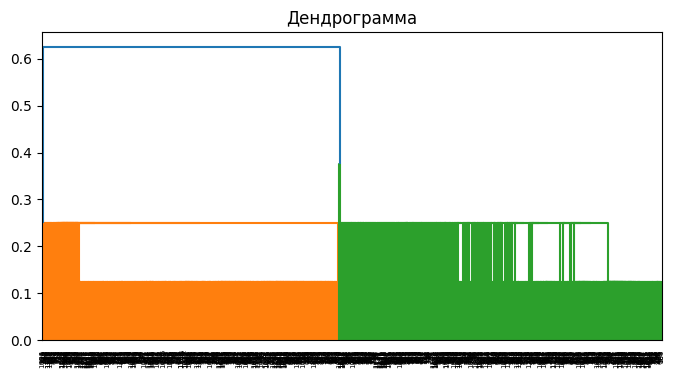

Кластеры при разбиении на 3 группы: [1 2 1 ... 2 1 1]


In [ ]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

# Преобразуем в конденсированную форму, 
from scipy.spatial.distance import squareform
condensed_dist = squareform(distance_matrix)

# Построение дендрита (иерархической кластеризации)
Z = linkage(condensed_dist, method='single')  

# Визуализация дендрограммы
plt.figure(figsize=(8, 4))
dendrogram(Z)
plt.title("Дендрограмма")
plt.show()

# Фиксированное число групп
n_groups = 2  # например, хотим разбить на 2 группы

# Получаем метки кластеров, удалив n-1 самых длинных связей
clusters = fcluster(Z, t=n_groups, criterion='maxclust')
print(f"Кластеры при разбиении на {n_groups} группы:", clusters)


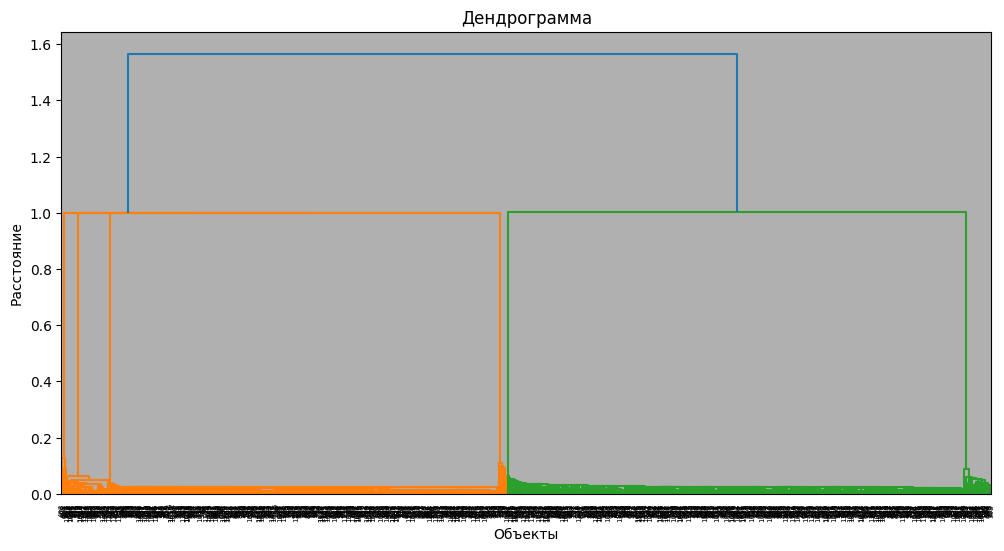

In [104]:
X_t = compute_distance_matrix(X.values, 'euclidean')

# Конвертация в numpy-массив
X_t_np = np.array(X_t)

# Создаём копию для симметризации, чтобы исходный массив не изменялся
X_t_sym = (X_t_np + X_t_np.T) / 2

# Построение дендрограммы
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import numpy as np

condensed_dist = squareform(X_t_sym)
linked = linkage(condensed_dist, method='single')

plt.figure(figsize=(12, 6))
dendrogram(linked, labels=np.arange(len(X_t_sym)), leaf_rotation=90)
plt.title('Дендрограмма')
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.grid(True)
plt.show()


Вывод статистики по кластерам

In [105]:
# Создаём копию, чтобы не трогать оригинальный датафрейм
df_analysis = X.copy()

df_analysis['cluster'] = clusters
# Сопоставление числовых значений типам личности
personality_map = {0.0: 'Интроверт', 1.0: 'Экстраверт'}

print("Описание кластеров:\n")

for cluster_id in sorted(df_analysis['cluster'].unique()):
    cluster_data = df_analysis[df_analysis['cluster'] == cluster_id]
    dominant_personality_code = cluster_data['Personality'].mode()[0] if not cluster_data['Personality'].mode().empty else None
    dominant_personality = personality_map.get(dominant_personality_code, 'Неизвестно')

    print(f"\n - Кластер {cluster_id}:")
    print(f"  Размер: {len(cluster_data)} объектов")
    print(f"  Среднее время, проведённое в одиночестве: {cluster_data['Time_spent_Alone'].mean():.2f}")
    if 'Stage_fear' in cluster_data.columns:
        print(f"  Процент страдающих страхом сцены: {cluster_data['Stage_fear'].mean() * 100:.1f}%")
    else:
        print("  Нет данных о страхе сцены")
    print(f"  Средняя посещаемость соц. событий: {cluster_data['Social_event_attendance'].mean():.2f}")
    print(f"  Среднее количество выходов на улицу: {cluster_data['Going_outside'].mean():.2f}")
    if 'Drained_after_socializing' in cluster_data.columns:
        print(f"  Процент уставших после общения: {cluster_data['Drained_after_socializing'].mean() * 100:.1f}%")
    else:
        print("  Нет данных об усталости после общения")
    print(f"  Средний размер круга друзей: {cluster_data['Friends_circle_size'].mean():.2f}")
    print(f"  Средняя частота публикаций: {cluster_data['Post_frequency'].mean():.2f}")
    print(f"  Тип личности в кластере: {dominant_personality}")


Описание кластеров:


 - Кластер 1:
  Размер: 556 объектов
  Среднее время, проведённое в одиночестве: 0.68
  Процент страдающих страхом сцены: 98.7%
  Средняя посещаемость соц. событий: 0.15
  Среднее количество выходов на улицу: 0.15
  Процент уставших после общения: 98.0%
  Средний размер круга друзей: 0.19
  Средняя частота публикаций: 0.11
  Тип личности в кластере: Интроверт

 - Кластер 2:
  Размер: 603 объектов
  Среднее время, проведённое в одиночестве: 0.15
  Процент страдающих страхом сцены: 0.0%
  Средняя посещаемость соц. событий: 0.64
  Среднее количество выходов на улицу: 0.70
  Процент уставших после общения: 0.0%
  Средний размер круга друзей: 0.65
  Средняя частота публикаций: 0.60
  Тип личности в кластере: Экстраверт

 - Кластер 3:
  Размер: 1 объектов
  Среднее время, проведённое в одиночестве: 0.00
  Процент страдающих страхом сцены: 0.0%
  Средняя посещаемость соц. событий: 0.90
  Среднее количество выходов на улицу: 0.86
  Процент уставших после общения: 0.0%
  С

Признаки для анализа

In [101]:
# Признаки для анализа
numeric_features = [
    'Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
    'Friends_circle_size', 'Post_frequency'
]

binary_features = [
    'Stage_fear', 'Drained_after_socializing'
]

# Средние значения признаков по кластерам
cluster_means = df_analysis.groupby('cluster')[numeric_features + binary_features].mean()

# Для отображения значений типа личности
personality_map = {0.0: 'Интроверт', 1.0: 'Экстраверт'}

# Добавим анализ личности по кластерам
personality_mode = df_analysis.groupby('cluster')['Personality'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

print("Анализ признаков по кластерам:\n")

for feature in numeric_features + binary_features:
    print(f"\n- Признак: {feature}")
    feature_values = cluster_means[feature]
    max_cluster = feature_values.idxmax()
    min_cluster = feature_values.idxmin()
    diff = feature_values[max_cluster] - feature_values[min_cluster]

    if feature in numeric_features:
        print(f"  Наибольшее значение ({feature_values[max_cluster]:.2f}) в кластере {max_cluster}")
        print(f"  Наименьшее значение ({feature_values[min_cluster]:.2f}) в кластере {min_cluster}")
        print(f"  Разница между кластерами: {diff:.2f}")
    else:
        print(f"  Наибольшая доля (≈{feature_values[max_cluster]*100:.1f}%) в кластере {max_cluster}")
        print(f"  Наименьшая доля (≈{feature_values[min_cluster]*100:.1f}%) в кластере {min_cluster}")
        print(f"  Разница между кластерами: {diff*100:.1f}%")

print("\nАнализ типов личности по кластерам:")
for cluster_id, p_code in personality_mode.items():
    p_name = personality_map.get(p_code, "Неизвестно")
    print(f" - Кластер {cluster_id}: доминирующий тип личности — {p_name}")


Анализ признаков по кластерам:


- Признак: Time_spent_Alone
  Наибольшее значение (0.68) в кластере 1
  Наименьшее значение (0.00) в кластере 3
  Разница между кластерами: 0.68

- Признак: Social_event_attendance
  Наибольшее значение (0.90) в кластере 3
  Наименьшее значение (0.15) в кластере 1
  Разница между кластерами: 0.75

- Признак: Going_outside
  Наибольшее значение (0.86) в кластере 3
  Наименьшее значение (0.15) в кластере 1
  Разница между кластерами: 0.70

- Признак: Friends_circle_size
  Наибольшее значение (0.65) в кластере 2
  Наименьшее значение (0.19) в кластере 1
  Разница между кластерами: 0.46

- Признак: Post_frequency
  Наибольшее значение (0.90) в кластере 3
  Наименьшее значение (0.11) в кластере 1
  Разница между кластерами: 0.79

- Признак: Stage_fear
  Наибольшая доля (≈98.7%) в кластере 1
  Наименьшая доля (≈0.0%) в кластере 2
  Разница между кластерами: 98.7%

- Признак: Drained_after_socializing
  Наибольшая доля (≈98.0%) в кластере 1
  Наименьшая доля (

Индекс силуэта для кластеризации Вроцлавской таксономии

k =  2, Silhouette Score = 0.7190
k =  3, Silhouette Score = 0.6141
k =  4, Silhouette Score = 0.5898
k =  5, Silhouette Score = 0.5531
k =  6, Silhouette Score = 0.5654
k =  7, Silhouette Score = 0.5773
k =  8, Silhouette Score = 0.5657
k =  9, Silhouette Score = 0.5603
k = 10, Silhouette Score = 0.5561


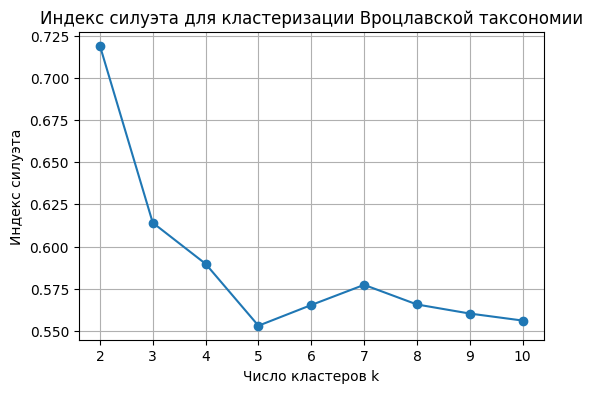

In [96]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

n = data.shape[0]

# Построение графа со взвешенными рёбрами из матрицы расстояний D
G = nx.Graph()
for i in range(n):
    for j in range(i + 1, n):
        G.add_edge(i, j, weight=D[i, j])

# Минимальное остовное дерево
T_original = nx.minimum_spanning_tree(G)

max_k = 10
ks = list(range(2, max_k + 1))
silhouettes = []

for k in ks:
    T = T_original.copy()
    # Удаляем (k-1) самых длинных рёбер
    longest = sorted(T.edges(data=True), key=lambda e: e[2]['weight'], reverse=True)[:k-1]
    for u, v, _ in longest:
        T.remove_edge(u, v)
    labels_k = np.zeros(n, dtype=int)
    for idx, comp in enumerate(nx.connected_components(T)):
        labels_k[list(comp)] = idx
    # Вычисляем индекс силуэта
    sil_score = silhouette_score(data.values if hasattr(data, "values") else data, labels_k)
    silhouettes.append(sil_score)

for k, sil in zip(ks, silhouettes):
    print(f"k = {k:2d}, Silhouette Score = {sil:.4f}")

# График
plt.figure(figsize=(6, 4))
plt.plot(ks, silhouettes, '-o')
plt.xlabel("Число кластеров k")
plt.ylabel("Индекс силуэта")
plt.title("Индекс силуэта для кластеризации Вроцлавской таксономии")
plt.xticks(ks)
plt.grid(True)
plt.show()


 Индекс Калински-Харабаша для кластеров Вроцлавской таксономии

k =  2, Calinski-Harabasz = 13836.08
k =  3, Calinski-Harabasz = 6944.72
k =  4, Calinski-Harabasz = 5802.83
k =  5, Calinski-Harabasz = 5286.76
k =  6, Calinski-Harabasz = 4630.72
k =  7, Calinski-Harabasz = 4217.31
k =  8, Calinski-Harabasz = 3617.62
k =  9, Calinski-Harabasz = 3166.68
k = 10, Calinski-Harabasz = 2815.49


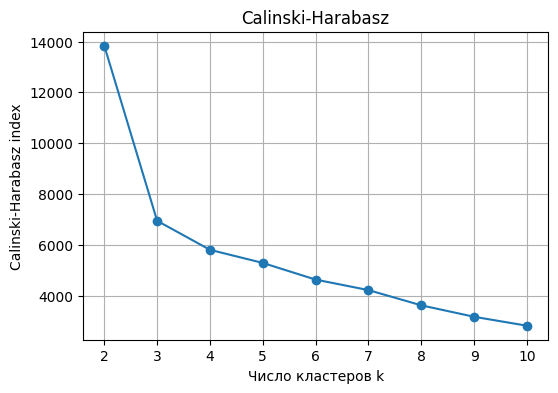

In [97]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score

n = data.shape[0]

G = nx.Graph()
for i in range(n):
    for j in range(i+1, n):
        G.add_edge(i, j, weight=D[i, j])
T_original = nx.minimum_spanning_tree(G)

max_k = 10
ks = list(range(2, max_k + 1))
chs = []

for k in ks:
    T = T_original.copy()
    longest = sorted(T.edges(data=True), key=lambda e: e[2]['weight'], reverse=True)[:k-1]
    for u, v, _ in longest:
        T.remove_edge(u, v)
    labels_k = np.zeros(n, dtype=int)
    for idx, comp in enumerate(nx.connected_components(T)):
        labels_k[list(comp)] = idx
    chs.append(calinski_harabasz_score(data.values if hasattr(data, "values") else data, labels_k))

for k, ch in zip(ks, chs):
    print(f"k = {k:2d}, Calinski-Harabasz = {ch:.2f}")

# График
plt.figure(figsize=(6,4))
plt.plot(ks, chs, '-o')
plt.xlabel("Число кластеров k")
plt.ylabel("Calinski-Harabasz index")
plt.title("Calinski-Harabasz")
plt.xticks(ks)
plt.grid(True)
plt.show()


## Визуализация результатов

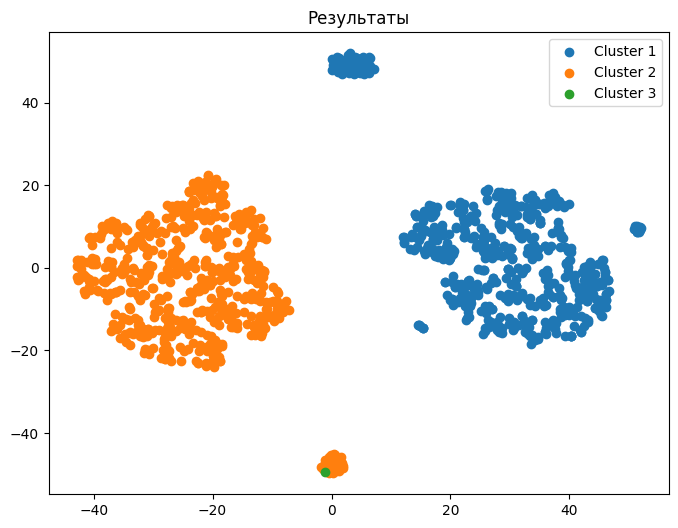

In [102]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# clusters получены для X (40% подвыборки)
labels_sub = clusters

# Используем те же объекты X (подвыборка нормализованного датасета)
X_sub = X.values  

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sub)

plt.figure(figsize=(8,6))
for lbl in np.unique(labels_sub):
    plt.scatter(X_tsne[labels_sub == lbl, 0], X_tsne[labels_sub == lbl, 1], label=f'Cluster {lbl}')
plt.legend()
plt.title('Результаты')
plt.show()
